In [2]:
from setup_triton import setup_triton

# TRITON_INTERPRET=1 uses a python interpreter instead of running on the GPU. 
# This menas that uou can insert Python breakpoints to debug your kernel code! 
setup_triton(use_interpreter=False, print_autotuning=True)

# Triton Puzzle 4: Matrix Multiplication

Welcome to the fourth Triton puzzle! Matrix multiplication is a fundamental operation in deep learning and a perfect example to learn advanced GPU optimization techniques.

### What you'll learn:
- 2D block tiling for data reuse
- Working with 2D program grids
- Introduction to `num_stages` for software pipelining
- **Auto-tuning**: Automatically finding optimal parameters
- Accumulation patterns in SRAM
- Why matmul achieves much higher arithmetic intensity than previous operations

## Mathematical Background

Matrix multiplication computes $\mathbf{C} = \mathbf{A} \times \mathbf{B}$ where:
- $\mathbf{A}$ is an $(M, K)$ matrix
- $\mathbf{B}$ is a $(K, N)$ matrix  
- $\mathbf{C}$ is an $(M, N)$ matrix

Each element is computed as:

$C_{ij} = \sum_{k=1}^{K} A_{ik} \cdot B_{kj}$


### Naive Strategy

The simplest method for matrix multiplication is to iterate over rows and columns:

```python
for m in range(0, M):
    for n in range(0, N):
        for k in range(0, K):
            # Load element A_{m,k}
            a = A[m, k]
            # Load element B_{k,n}
            b = B[k, n]
            # Accumulate and store direct into C_{m, n}
            C[m, n] += a * b
```

- **Total FLOPs:** 2MNK due to one multiply + one add per (m, n, k) triplet
- **Memory traffic:**
    - A reads: $MKN$
    - B reads: $MKN$
    - C writes: $MN$
    - **Total:** $2MKN + MN$

Can we do better?


### The Tiling Strategy

Since matrices often don't fit in SRAM, we use **block tiling**. This image helps to explain the process:

<img src="./figs/tiled-outer-prod.svg" width="512" />

Pseudocode:

```python
# B_M  = BLOCK_SIZE_M (tile size for A' rows)
# B_N  = BLOCK_SIZE_N (tile size for B' cols)
# B_K  = BLOCK_SIZE_K (tile size for inner dim)

for m in range(0, M, B_M):
    for n in range(0, N, B_N):
        # Initialize accumulator for C in SRAM
        acc = zeros((B_M, B_N))
        for k in range(0, K, B_K):
            # Load blocks into SRAM
            a = A[m:m+B_M, k:k+B_K]
            b = B[k:k+B_K, n:n+B_N]
            # Accumulate in SRAM
            acc += a @ b
        # Store result
        C[m:m+B_M, n:n+B_N] = acc
```

- **Total FLOPs:** still 2MNK (same computation, different order)
- **Memory traffic:**
  - A reads: $MK \times (N/B_N) = MKN/B_N$
  - B reads: $KN \times (M/B_M) = MKN/B_M$
  - C writes: $MN$
  - **Total:** $MKN(1/B_N + 1/B_M) + MN$

### Comparison

For $B_M = B_N = B$, we have:

- **Naive approach:** $2MKN + MN$ bytes of memory traffic
- **Tiled approach:** $2MKN/B + MN$ bytes of memory traffic
- **Memory traffic reduction:** $\approx B\times$ for large $K$

<font color="green"><b>
    This is why tiling is so powerful! We've reduced memory traffic by the block size factor while doing exactly the same computation.</b></font> 


### Key Insight: Arithmetic Intensity

$\text{Arithmetic Intensity} = \dfrac{\text{FLOPs}}{\text{moved bytes}}$

- **Naive approach:** $2MNK / (2MNK + MN) \approx 1 \text{ FLOP/byte }$
- **Tiled approach (B=128):** $2MNK / (2MNK/128 + MN) \approx 128 \, \text{ FLOPs/byte }$

<font color="green"><b>
    This massive increase in arithmetic intensity is what makes matrix multiplication so efficient on GPUs!
</b></font> 

<font color="red"><b>
    As long as our blocks fit in SRAM, we are good to go!
</b></font>

So, let's code a matmul in Triton.

In [3]:
import torch
import triton
import triton.language as tl
import numpy as np
from IPython.display import display, Image

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Set random seed
torch.manual_seed(42)

Using device: cuda


## Implementation 1: PyTorch Built-in

First, let's see PyTorch's built-in implementation, which uses highly optimized cuda kernels:


In [4]:
def matmul_pytorch(A, B):
    """PyTorch's built-in matrix multiplication."""
    return torch.matmul(A, B)

## Implementation 2: PyTorch Compiled

Let's see a naive triply-nested loop implementation optimized with torch.compile:

In [5]:
@torch.compile
def matmul_compiled(A, B, BLOCK_SIZE_M=64, BLOCK_SIZE_N=64, BLOCK_SIZE_K=32):
    M, K = A.shape
    _, N = B.shape
    C = torch.zeros((M, N), dtype=A.dtype, device=A.device)
    for m in range(0, M, BLOCK_SIZE_M):
        for n in range(0, N, BLOCK_SIZE_N):
            # no accumulator for simplicity
            for k in range(0, K, BLOCK_SIZE_K):
                a = A[m : m+BLOCK_SIZE_M, k : k+BLOCK_SIZE_K]
                b = B[k : k+BLOCK_SIZE_K, n : n+BLOCK_SIZE_N]
                C[m : m+BLOCK_SIZE_M, n : n+BLOCK_SIZE_N] += a @ b
    return C


# Warmup & test correctness
# A = torch.randn(128, 128)
# B = torch.randn(128, 128)
# C_ref = matmul_pytorch(A, B)
# C_comp = matmul_compiled(A, B)
# torch.allclose(C_ref, C_comp, atol=1e-4)

## Implementation 3: Triton Kernel (Puzzle)

Key concepts for this puzzle:

### 1. 2D Program Grids
- Programs are organized in a 2D grid: `(M/BLOCK_SIZE_M, N/BLOCK_SIZE_N)`
- Each program computes one output block
- Use `tl.program_id(0)` and `tl.program_id(1)` for row and column indices, respectively

### 2. Accumulation Pattern
- Initialize accumulator in SRAM: `acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)`
- Loop over K dimension, accumulating partial results
- Only write to HBM once at the end

### 3. Software Pipelining with `num_stages`
- **num_stages** controls how many iterations of a loop can be "parallelized"
    - I don't excatly know how it works, but usually num_stages > 1 improves performance
    - That is, higher values allow some "overlapping memory loads", which helps computation
    - Example: While computing on data from iteration `i`, we can load data for iteration `i+1`

### 4. Auto-tuning Introduction
- Different matrix sizes benefit from different block sizes
- Triton can automatically test multiple configurations
- We'll use `@triton.autotune` decorator


Now implement matrix multiplication in Triton!

### Your Task:
1. Set up 2D program indices
2. Initialize accumulator
3. Loop over K dimension in blocks
4. Load blocks of A and B
5. Accumulate using `tl.dot`
6. Store final result

In [6]:
# First, let's define configurations for auto-tuning
# These values are largely empirical and many people usually just copy from each other
# A rule of thumb is to ALWAYS use values that are a power of 2
configs = [
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64}, num_stages=2, num_warps=8),
    triton.Config({'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32}, num_stages=3, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
]
@triton.autotune(
    configs=configs,
    key=['M', 'N', 'K'],  # Autotune based on matrix dimensions 
                          # when these values change, Triton will tune the tl.constexpr args!
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # Strides
    stride_am, stride_ak,  # A matrix strides
    stride_bk, stride_bn,  # B matrix strides  
    stride_cm, stride_cn,  # C matrix strides
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, 
    BLOCK_SIZE_N: tl.constexpr, 
    BLOCK_SIZE_K: tl.constexpr,
):
    """
    Kernel for computing C = A @ B.
    
    Each program computes a [BLOCK_SIZE_M, BLOCK_SIZE_N] block of C.
    
    Key concepts:
    - 2D program grid: programs are indexed by (pid_m, pid_n)
    - Accumulation: partial results stay in SRAM
    - Tiling: process K dimension in chunks of BLOCK_SIZE_K
    """

    # YOUR IMPLEMENTATION GOES HERE.
    # (We left you some helpful code here to kick it off)
    
    # Get program IDs for M and N dimensions
    pid_m = tl.program_id(0)  # Row block index
    pid_n = tl.program_id(1)  # Column block index
    
    # Set up offsets for this block
    offs_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_n = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    
    # Initialize accumulator
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    # Initialize pointers to blocks of A and B
    # todo
    
    # Loop over K dimension
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load A and B blocks, multiply, accumulate
        # todo
        
        # Use tl.dot() for matrix multiplication
        # todo
        pass
        
        
    # Store final result with appropriate masking
    # todo
    pass


def matmul_triton(a, b):
    """Wrapper for the Triton matmul kernel."""
    # Check dimensions
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    assert b.is_contiguous(), "Matrix B must be contiguous"
    
    M, K = a.shape
    K, N = b.shape
    
    # Allocate output
    c = torch.empty((M, N), device=a.device, dtype=a.dtype)
    
    # Create 2D launch grid
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']),
        triton.cdiv(N, META['BLOCK_SIZE_N']),
    )
    
    # Launch kernel
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    
    return c

## Understanding Auto-tuning

Let's see how auto-tuning selects the best configuration:

> If the environment variable TRITON_PRINT_AUTOTUNING is set to "1", <br>
> Triton will print a message to stdout after autotuning each kernel, <br>
> including the time spent autotuning and the best configuration.

In [7]:
def show_autotune_info():
    """Display information about auto-tuning."""
    print("Auto-tuning configurations:")
    print("-" * 80)
    print(f"{'Config':<10} {'BLOCK_M':<10} {'BLOCK_N':<10} {'BLOCK_K':<10} {'num_warps':<10} {'num_stages':<10}")
    print("-" * 80)
    
    for i, config in enumerate(configs):
        block_m = config.kwargs['BLOCK_SIZE_M']
        block_n = config.kwargs['BLOCK_SIZE_N']
        block_k = config.kwargs['BLOCK_SIZE_K']
        warps = config.num_warps
        stages = config.num_stages
        
        print(f"{i:<10} {block_m:<10} {block_n:<10} {block_k:<10} {warps:<10} {stages:<10}")
    
    print("\nAuto-tuning will test each configuration and select the fastest!")
    print("The best config depends on:")
    print("  - Matrix dimensions (M, N, K)")
    print("  - GPU architecture")
    print("  - Speed (default `bench` returns ms)")

show_autotune_info()

Auto-tuning configurations:
--------------------------------------------------------------------------------
Config     BLOCK_M    BLOCK_N    BLOCK_K    num_warps  num_stages
--------------------------------------------------------------------------------
0          128        256        64         8          2         
1          64         256        32         4          3         
2          128        128        32         4          4         
3          128        64         32         4          4         
4          64         128        32         4          4         

Auto-tuning will test each configuration and select the fastest!
The best config depends on:
  - Matrix dimensions (M, N, K)
  - GPU architecture
  - Speed (default `bench` returns ms)


## Solution(s) 🧙

You shall not pass!

### Standard Solution

Use a 2D grid and recover blocks with `tl.program_id(axis=0)` and `tl.program_id(axis=1)`

In [8]:
configs = [
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64}, num_stages=2, num_warps=8),
    triton.Config({'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32}, num_stages=3, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4, num_warps=4),
]
@triton.autotune(
    configs=configs,
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
    a_ptr, b_ptr, c_ptr,
    M, N, K,
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
):
    """Kernel for computing C = A @ B."""
    # Get program ID in 2D grid
    pid_m = tl.program_id(0)  # Block row index
    pid_n = tl.program_id(1)  # Block column index
    
    # Create 1D offset arrays for the M and N dimensions
    offs_m = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_n = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    
    # Initialize accumulator for this output block
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    # Initialize pointers to blocks of A and B
    # A block: [BLOCK_SIZE_M, BLOCK_SIZE_K]
    # B block: [BLOCK_SIZE_K, BLOCK_SIZE_N]
    a_ptrs = a_ptr + (offs_m[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_n[None, :] * stride_bn)
    
    # Loop over K dimension in blocks
    # Note: We use regular Python range() which gets unrolled at compile time
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Create masks for boundary checking
        mask_a = (offs_m[:, None] < M) & (offs_k[None, :] < K - k * BLOCK_SIZE_K)
        mask_b = (offs_k[:, None] < K - k * BLOCK_SIZE_K) & (offs_n[None, :] < N)
        
        # Load blocks from A and B (load 0 for out-of-bounds)
        a = tl.load(a_ptrs, mask=mask_a, other=0.0)
        b = tl.load(b_ptrs, mask=mask_b, other=0.0)
        
        # Matrix multiply and accumulate
        acc += tl.dot(a, b)
        
        # Advance pointers to next K block
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    
    # Convert accumulator to output dtype
    # acc = acc.to(c_ptr.dtype.element_ty)
    
    # Store output block
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    mask_c = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, acc, mask=mask_c)


### L2 Cache Optimizations

As per the original tutorial: https://triton-lang.org/main/getting-started/tutorials/03-matrix-multiplication.html

If we want to maximize L2 cache hit rate, we need to move from a simple row-major ordering to a grou-based ordering. 
This assumes you have a single axis of parallelism (rows) and thus you need to be smart in how you index the columns.
This can be done by "super-grouping" blocks in groups of GROUP_M rows before switching to the next column.

> For example, in the following matmul where each matrix is 9 blocks by 9 blocks, we can see that if we compute the output in row-major ordering, we need to load 90 blocks into SRAM to compute the first 9 output blocks, but if we do it in grouped ordering, we only need to load 54 blocks.

<img src="https://triton-lang.org/main/_images/grouped_vs_row_major_ordering.png" width="800" />

In [9]:
configs = [
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=8),
    triton.Config({'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=3, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64,  'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
    triton.Config({'BLOCK_SIZE_M': 64,  'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4, num_warps=4),
]
@triton.autotune(
    configs=configs,
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel_advanced(
    a_ptr, b_ptr, c_ptr,
    M, N, K,
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, num_stages: tl.constexpr
):
    """Kernel for computing C = A @ B."""
    # Program ID
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # Create block pointers
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    
    # Initialize pointers to A and B blocks
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # Initialize accumulator
    acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    
    # Loop over K dimension
    for k in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B
        # If we're out of bounds, load 0
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        
        # Matrix multiply and accumulate
        acc += tl.dot(a, b)
        
        # Advance the pointers
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    
    # Convert accumulator to output dtype
    # acc = acc.to(c_ptr.dtype.element_ty)
    
    # Store output
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, acc, mask=c_mask)

def matmul_triton_advanced(a, b):
    """Wrapper using the solution kernel."""
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    assert b.is_contiguous(), "Matrix B must be contiguous"
    
    M, K = a.shape
    K, N = b.shape
    
    c = torch.empty((M, N), device=a.device, dtype=a.dtype)
    
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
    )
    
    matmul_kernel_advanced[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    
    return c


- **Is it more efficient than our solution with a 2D grid? Why?** <font size="5">🤔</font>

## Testing Correctness

Let's verify our implementation:

Autotuning kernel matmul_kernel with config BLOCK_SIZE_M: 128, BLOCK_SIZE_N: 256, BLOCK_SIZE_K: 64, num_warps: 8, num_ctas: 1, num_stages: 2, num_buffers_warp_spec: 0, num_consumer_groups: 0, reg_dec_producer: 0, reg_inc_consumer: 0, maxnreg: None
Autotuning failed with out of resource: shared memory, Required: 98304, Hardware limit: 65536. Reducing block sizes or `num_stages` may help.
Autotuning kernel matmul_kernel with config BLOCK_SIZE_M: 64, BLOCK_SIZE_N: 256, BLOCK_SIZE_K: 32, num_warps: 4, num_ctas: 1, num_stages: 3, num_buffers_warp_spec: 0, num_consumer_groups: 0, reg_dec_producer: 0, reg_inc_consumer: 0, maxnreg: None
Autotuning kernel matmul_kernel with config BLOCK_SIZE_M: 128, BLOCK_SIZE_N: 128, BLOCK_SIZE_K: 32, num_warps: 4, num_ctas: 1, num_stages: 4, num_buffers_warp_spec: 0, num_consumer_groups: 0, reg_dec_producer: 0, reg_inc_consumer: 0, maxnreg: None
Autotuning kernel matmul_kernel with config BLOCK_SIZE_M: 128, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 32, num_warps: 4, nu

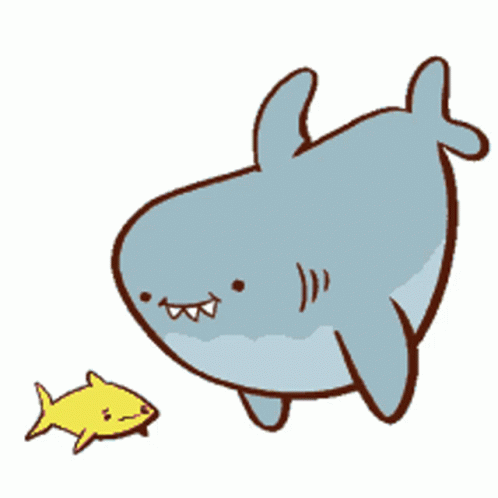

In [10]:
def test_correctness(M=512, N=512, K=512, atol=1e-4, rtol=1e-4):
    """Test if Triton implementation matches PyTorch."""
    torch.manual_seed(42)
    a = torch.randn(M, K, device=DEVICE, dtype=torch.float32)
    b = torch.randn(K, N, device=DEVICE, dtype=torch.float32)
    
    # Compute with PyTorch
    expected = matmul_pytorch(a, b)
    
    # Compute with Triton
    actual = matmul_triton(a, b)

    # Compute the advanced solution with Triton
    actual_advanced = matmul_triton_advanced(a, b)
    
    try:
        torch.testing.assert_close(actual, expected, atol=atol, rtol=rtol)
        print(f"✅ Test PASSED! Results match within tolerance.")
        print(f"   Matrix dimensions: ({M}, {K}) @ ({K}, {N})")
        print(f"   Max absolute difference: {(actual - expected).abs().max().item():.2e}")
        torch.testing.assert_close(actual_advanced, expected, atol=atol, rtol=rtol)
        print(f"✅ Test PASSED! Advanced results match within tolerance.")
        print(f"   Matrix dimensions: ({M}, {K}) @ ({K}, {N})")
        print(f"   Max absolute difference: {(actual_advanced - expected).abs().max().item():.2e}")
        return True
        
    except AssertionError as e:
        print(f"❌ Test FAILED!")
        print(f"   Error: {e}")
        return False

# Run tests
test_passed = test_correctness(M=512, N=512, K=512)
test_passed &= test_correctness(M=37, N=42, K=73)
test_passed &= test_correctness(M=128, N=256, K=64)

# Display congrats message
if test_passed:
    print("\n🎉 Congratulations! Your implementation is correct!")
    display(Image("figs/success.gif", width=256, height=256))

## FLOP and Memory Analysis

Matrix multiplication has much higher arithmetic intensity than our previous operations:

In [11]:
def analyze_matmul_ops(M, N, K, block_m=128, block_n=128, block_k=32):
    """Analyze operations for matrix multiplication."""
    
    # Total FLOPs: 2*M*N*K (multiply-add for each output element)
    total_flops = 2 * M * N * K
    
    # Memory analysis depends on blocking strategy
    element_size = 4  # float32
    
    # Naive approach: load A and B for each output element
    naive_memory = {
        'reads': M * N * K * 2 * element_size,  # Each output reads K elements from A and B
        'writes': M * N * element_size,
        'total': M * N * K * 2 * element_size + M * N * element_size
    }
    
    # Blocked approach: reuse data in SRAM
    # Each block of C requires:
    # - Load (K/block_k) blocks of A, each of size block_m * block_k
    # - Load (K/block_k) blocks of B, each of size block_k * block_n
    # - Store 1 block of C, size block_m * block_n
    
    num_blocks = (M // block_m) * (N // block_n)
    reads_per_block = (K // block_k) * (block_m * block_k + block_k * block_n) * element_size
    writes_per_block = block_m * block_n * element_size
    
    blocked_memory = {
        'reads': num_blocks * reads_per_block,
        'writes': num_blocks * writes_per_block,
        'total': num_blocks * (reads_per_block + writes_per_block)
    }
    
    # Arithmetic intensity (FLOPs per byte)
    blocked_ai = total_flops / blocked_memory['total']
    naive_ai = total_flops / naive_memory['total']
    
    return {
        'flops': total_flops,
        'naive_memory': naive_memory,
        'blocked_memory': blocked_memory,
        'naive_ai': naive_ai,
        'blocked_ai': blocked_ai,
        'ai_improvement': blocked_ai / naive_ai
    }

# Example analysis
M, N, K = 1024, 1024, 1024
analysis = analyze_matmul_ops(M, N, K)

print(f"Matrix multiplication {M}x{K} @ {K}x{N}:")
print(f"  Total FLOPs: {analysis['flops'] / 1e9:.2f} GFLOPs")
print(f"  Naive memory: {analysis['naive_memory']['total'] / 1e9:.2f} GB")
print(f"  Blocked memory: {analysis['blocked_memory']['total'] / 1e9:.2f} GB")
print(f"  Naive arithmetic intensity: {analysis['naive_ai']:.2f} FLOPs/byte")
print(f"  Blocked arithmetic intensity: {analysis['blocked_ai']:.2f} FLOPs/byte")
print(f"  AI improvement: {analysis['ai_improvement']:.1f}x")

Matrix multiplication 1024x1024 @ 1024x1024:
  Total FLOPs: 2.15 GFLOPs
  Naive memory: 8.59 GB
  Blocked memory: 0.07 GB
  Naive arithmetic intensity: 0.25 FLOPs/byte
  Blocked arithmetic intensity: 30.12 FLOPs/byte
  AI improvement: 120.5x


## Summary

You've just implemented one of the most important kernels in deep learning! Here's what you learned:

### Key Concepts Mastered:

1. **2D Block Tiling**: Maximizing data reuse by processing blocks
2. **Arithmetic Intensity**: Matmul achieves a much higher arithmic intensity than vector add
3. **Auto-tuning**: Automatically finding optimal configurations
4. **Software Pipelining**: Using `num_stages` to overlap compute and memory
5. **Accumulation**: Keeping partial results in SRAM

### Performance Insights:

- **Data Reuse**: Each element loaded participates in many operations
- **SRAM Utilization**: Accumulator stays in fast memory throughout K loop
- **Parallelism**: 2D grid exploits massive GPU parallelism
- **Auto-tuning**: Different sizes need different configurations

### Advanced Tips:

- Experiment with different `GROUP_SIZE_M` values for L2 cache optimization
- Try mixed precision (FP16 with FP32 accumulation) for even higher performance
- Consider Split-K parallelization for very large K dimensions

### Next Steps:

Ready for LayerNorm? The next puzzle introduces:
- Parallel reduction patterns
- Online algorithms (single-pass computation)
- Warp-level primitives
- Handling of statistics (mean, variance)

<img src="./figs/sardine-challenge.png" width="512" />

---

## Benchmarking (GPU only)

Now let's benchmark the implementations:

Running benchmarks...


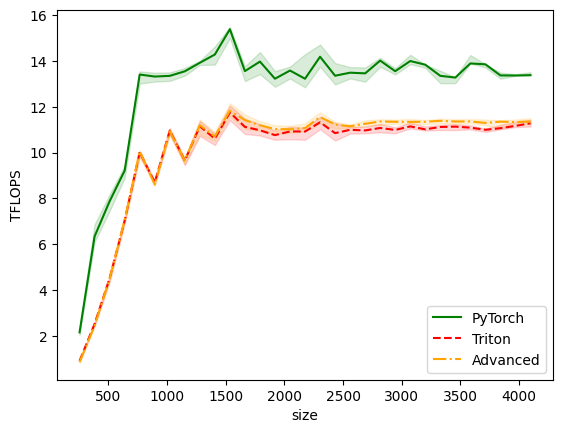

matmul-performance:
      size    PyTorch     Triton   Advanced
0    256.0   2.153133   0.910222   0.861607
1    384.0   6.342194   2.524211   2.447403
2    512.0   7.876628   4.519724   4.500326
3    640.0   9.212257   7.034779   7.062069
4    768.0  13.405091  10.021788  10.053818
5    896.0  13.316853   8.695880   8.607639
6   1024.0  13.347029  10.961023  10.924445
7   1152.0  13.545717   9.647280   9.644846
8   1280.0  13.917181  11.145578  11.191735
9   1408.0  14.278673  10.606568  10.700248
10  1536.0  15.381488  11.748751  11.825119
11  1664.0  13.554492  11.120709  11.417223
12  1792.0  13.969609  10.971480  11.190814
13  1920.0  13.222381  10.760071  11.025572
14  2048.0  13.578606  10.922666  11.014544
15  2176.0  13.221845  10.917111  11.069113
16  2304.0  14.180460  11.321350  11.551632
17  2432.0  13.352882  10.847284  11.221094
18  2560.0  13.485294  10.992918  11.145578
19  2688.0  13.456135  10.965143  11.255995
20  2816.0  14.012386  11.072802  11.355372
21  2944.0  

In [14]:
# disable print autotuning
import os
os.environ["TRITON_PRINT_AUTOTUNING"] = "0"

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Square matrix size
        x_vals=[128 * i for i in range(2, 33)],
        line_arg='provider',
        line_vals=['pytorch', 'triton', 'triton_advanced'],
        line_names=['PyTorch', 'Triton', 'Advanced'],
        styles=[('green', '-'), ('red', '--'), ('orange', '-.')],
        ylabel='TFLOPS',
        plot_name='matmul-performance',
        args={},
    )
)
def benchmark(size, provider):
    """Benchmark matrix multiplication."""
    M = N = K = size
    a = torch.randn(M, K, device=DEVICE, dtype=torch.float32)  # try changing to float16
    b = torch.randn(K, N, device=DEVICE, dtype=torch.float32)  # try changing to float16
    
    quantiles = [0.5, 0.05, 0.95]
    
    if provider == 'pytorch':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: matmul_pytorch(a, b), quantiles=quantiles
        )
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: matmul_triton(a, b), quantiles=quantiles
        )
    elif provider == 'triton_advanced':
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: matmul_triton_advanced(a, b), quantiles=quantiles
        )
    
    # Calculate TFLOPS
    flops = 2 * M * N * K
    tflops = lambda ms: flops * 1e-12 / (ms * 1e-3)
    
    return tflops(ms), tflops(max_ms), tflops(min_ms)

print("Running benchmarks...")
results = benchmark.run(show_plots=True, print_data=True, return_df=True, save_path='')

## Speedup?

In [15]:
# Check if Triton is faster than PyTorch
avg_pytorch = results['PyTorch'].mean()
avg_triton = results['Triton'].mean()
speedup = avg_triton / avg_pytorch

if speedup > 1.0:
    print(f"\n🚀 Awesome! Triton is {speedup:.2f}x faster than PyTorch!")
    display(Image("figs/gpu.gif", width=400, height=256))
else:
    print(f"\n🐌 Not quite yet! Triton implementation is {speedup:.2f}x slower than PyTorch!")


🐌 Not quite yet! Triton implementation is 0.78x slower than PyTorch!
